# Import modules

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, zscore

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, RobustScaler, MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings("ignore")

# Load data

In [122]:
# Load the dataset
auto = pd.read_csv("adverts.csv")

In [123]:
seed = 42

In [124]:
auto = auto.sample(50000, random_state=seed)

# Identify erroneous data

### Price

In [125]:
# Drop rows with unrealistic prices
auto = auto.loc[auto["price"] != 9999999]

### Mileage

In [126]:
# Very low mileage is likely erroneous for older used cars
auto.loc[
    (auto["mileage"] <= 100) & 
    (auto["vehicle_condition"] == "USED") & 
    (auto["year_of_registration"] < 2018), 
    "mileage"] = np.nan

### Year of reg

In [127]:
# Set the years of reg for new cars to 2020
auto.loc[(auto["vehicle_condition"]=="NEW") & (auto["year_of_registration"].isna()), "year_of_registration"] = 2020

In [128]:
# Remove very old years for non-old makes
# Note for me: "~"" means not
auto.loc[(auto["year_of_registration"] < 1950) & (~auto["standard_make"].isin(["Austin", "Morris"])), "year_of_registration"] = np.nan

### Reg code

In [129]:
class RegCodeToYear(BaseEstimator, TransformerMixin):
    '''
    Converts reg codes into years based on the letter or number.
    For letter codes there are two possible corresponding years,
    so both years are saved as a tuple.  
    '''
    def __init__(self, column="reg_code", target_column="reg_code_year"):
        self.column = column
        self.target_column = target_column

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        if not(self.column in X):
            print("Skipping reg code to year as no reg code column is present.")
            return X
        
        def reg_to_year(reg_code):
            try:
                reg_code = int(reg_code)
                if reg_code > 71 or (50 > reg_code > 20): return np.nan
                return 2000 + reg_code % 50
            except (ValueError, TypeError):
                if not isinstance(reg_code, str): return np.nan
                letters = "ABCDEFGHJKLMNPRSTXY"
                if reg_code == "V": return (1979, 1999)
                if reg_code == "W": return (1980, 2000)
                if reg_code not in letters: return np.nan
                return (1983 + letters.find(reg_code), 1963 + letters.find(reg_code))

        # Apply the reg_to_year function and create the target column
        X[self.target_column] = X[self.column].map(reg_to_year)
        return X

In [130]:
class RegYearDisambiguator(BaseEstimator, TransformerMixin):
    '''
    Some letter reg codes can match to two different years e.g. "A" maps to both 1963 and 1983.
    This transformer finds the mean year of other cars of the same model and picks whichever of
    the two is closer to that mean. If there are no matching models of car the most recent year
    is taken as newer cars are more common in the dataset.
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if not("reg_code" in X or "year_of_registration" in X or "reg_code_year" in X):
            print("Skipping reg year disambiguation as year is not present")
            return X
        
        def is_alpha(val):
            try: return not val.isnumeric()
            except: return False
            
        missing = X[(X["reg_code"].apply(is_alpha)) & (X["year_of_registration"].isna())]

        # For each ambiguous year select the year closest to the mean for that make.
        missing = missing.loc[missing["reg_code_year"].notna()]
        full_missing = X.loc[missing.index]

        for i in range(len(full_missing)):
            missing_model = full_missing.iloc[i]["standard_model"]
            years = full_missing.iloc[i]["reg_code_year"]
            used = X.loc[(X["standard_model"] == missing_model) & (X["year_of_registration"].notna())]

            mean_year = np.array(used["year_of_registration"]).mean()
            closest_year = years[0] if abs(mean_year - years[0]) < abs(mean_year - years[1]) else years[1]

            X.at[missing.index[i], "reg_code_year"] = closest_year

        return X

In [131]:
class FillYearWithReg(BaseEstimator, TransformerMixin):
    ''' Fill in missing year_of_registrations with the parsed data from the reg code.'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if not("reg_code" in X or "year_of_registration" in X or "reg_code_year" in X):
            print("Skipping fill year with reg as columns are not present.")
            return X

        # Copy the year from the reg code for missing years then drop reg code and reg code year
        X.loc[auto["year_of_registration"].isna(), "year_of_registration"] = X["reg_code_year"]

        X.drop(columns=["reg_code", "reg_code_year"], inplace=True)
        
        return X

# Process data for model

In [132]:
class AutoEncodeBinary(BaseEstimator, TransformerMixin):
    ''' Find non numeric features with only two values and replace them with 0 and 1'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        for col in X:
            if isinstance(col, (str, bool))  and len(X[col].unique()) == 2:
                X[col] = X[col].replace({X[col].unique()[0]:0, X[col].unique()[1]:1})

        return X

In [133]:
class ParseReference(BaseEstimator, TransformerMixin):
    """ Extract date (in days) from public reference and then drop the column. """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if not "public_reference" in X:
            print("Skipping ParseReference as no public reference found in frame.")
            return X

        time = pd.DataFrame()
        time["year"] = X["public_reference"].astype(str).str[:4].astype(int)
        time["month"] = X["public_reference"].astype(str).str[4:6].astype(int)
        time["day"] = X["public_reference"].astype(str).str[6:8].astype(int)
        X["public_reference"] = round(time["year"]*365.25 + time["month"]*30.436875 + time["day"]).astype(int)
        X = X.rename(columns={"public_reference": "reference"})

        return X

In [134]:
class MergeColours(BaseEstimator, TransformerMixin):
    """ Combines similar colours with few entries. """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if not "standard_colour" in X:
            print("Skipping MergeColours as no standard_colour found in frame.")
            return X

        X = X.replace({
            "Navy": "Blue", 
            "Magenta": "Pink", 
            "Burgundy": "Maroon", 
            "Indigo": "Purple"
            })

        return X

In [135]:
class RemoveMileageOutliers(BaseEstimator, TransformerMixin):
    """ Remove outliers beyond a certain z value for a mileage. """
    
    def __init__(self, z_threshold:int=3):
        self.z_threshold = z_threshold

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        miles = X.copy().loc[(X["mileage"].notna()) & X["year_of_registration"].notna()]
        miles["years_to_2020"] = 2021 - miles["year_of_registration"]
        miles["miles_per_year"] = round(miles["mileage"] / miles["years_to_2020"]).astype(np.int64)
        miles["z"] = np.abs(zscore(miles['miles_per_year']))

        X.loc[miles.loc[miles["z"] > self.z_threshold].index, "mileage"] = np.nan

        return X

In [136]:
class CombineMakeModel(BaseEstimator, TransformerMixin):
    '''Combine the makes and models into a single feature.'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Combine make and model into one column
        X = pd.DataFrame(X, columns=["standard_colour", "standard_make", "standard_model", "vehicle_condition", "body_type", "crossover_car_and_van", "fuel_type"])
        X["make_model"] = X["standard_make"] + " " + X["standard_model"]
        X.drop(columns=["standard_make", "standard_model"], inplace=True)

        return X

In [137]:
class ImportanceImputer(BaseEstimator, TransformerMixin):
    '''
    Imputes categorical data by taking the mode of data which match other
    categorical features. The other categorical features are sorted based
    on their correlation with the target feature. To find the correlation
    Cramer's V is used. The imputer first attempts to locate entries that
    match every feature e.g. finding cars with the same make, model, year
    and condition. If no match is found, then the least important feature
    is ignored and the process continues until a minimum matching entries
    are found. Once found, the modes of the matches are filled in the gap.

    '''
    def __init__(self, impute_features, similar_threshold=1):
        self.impute_features = impute_features
        self.similar_threshold = similar_threshold
        self.ordered_features = {}

    def fit(self, X, y=None):
        X = X.copy()
        
        # Identify numeric and categorical features
        numerical_features = list(set(X.select_dtypes(include=[np.number]).columns))
        self.categorical_features_ = list(set(X.columns) - set(numerical_features))

        for feature in self.impute_features:
            # Compute Cramér"s V for categorical features
            self.cramer_dict_ = {}
            for feat in self.categorical_features_:
                if feat == feature: next
                
                contingency_table = pd.crosstab(X[feat], X[feature])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                r, k = contingency_table.shape
                cramer_v = np.sqrt((chi2 / n) / (min(r, k) - 1))
                self.cramer_dict_[feat] = cramer_v

            self.cramer_dict_ = dict(sorted(self.cramer_dict_.items(), key=lambda x: -x[1]))

            ordered_features = list(self.cramer_dict_.keys())
            if feature in ordered_features: ordered_features.remove(feature)
            self.ordered_features[feature] = ordered_features

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.impute_features:
            # Impute missing values
            missing_indices = X[X[feature].isna()].index

            def impute_value(row):
                features_to_match = self.ordered_features[feature].copy()
                while features_to_match:
                    condition = True
                    for feat in features_to_match:
                        condition &= X[feat] == row[feat]
                    similar_entries = X.loc[condition & X[feature].notna()]
                    if len(similar_entries) >= self.similar_threshold:
                        return similar_entries[feature].mode()[0]
                    features_to_match.pop()

                return X[feature].mode()[0]

            # Apply imputation
            X.loc[missing_indices, feature] = X.loc[missing_indices].apply(impute_value, axis=1)

        return X

# Split data

In [138]:
cat_features = ["year_of_registration", "standard_colour", "standard_make", "standard_model", "vehicle_condition", "body_type", "crossover_car_and_van", "fuel_type"]
num_features = ["reference", "mileage", "year_of_registration"]

general_process = Pipeline([
    ("r2y", RegCodeToYear()),
    ("ryd", RegYearDisambiguator()),
    ("fyr", FillYearWithReg()),
    ("aeb", AutoEncodeBinary()),
    ("par", ParseReference()),
    ("col", MergeColours()),
    # ("out", RemoveMileageOutliers()),
])
cat_pipe = Pipeline([
    ("imp", ImportanceImputer(impute_features=cat_features)),
    # ("imp", SimpleImputer(strategy="most_frequent")),
    ("cmm", CombineMakeModel()),
    ("ohenc", OneHotEncoder(sparse_output=False, handle_unknown="ignore", dtype=int))
])
num_pipe = Pipeline([
    ("imp", KNNImputer()),
    ("scl", RobustScaler()),
    ("tsf", PowerTransformer()),
    ("scl2", MinMaxScaler()),
])
col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ])
preprocessor = Pipeline([
    ("gen", general_process),
    ("pre", col_transformer)
])

In [139]:
knn_pipeline = Pipeline([
    ("pp", preprocessor),
    ("knn", KNeighborsRegressor(5))
])

dtr_pipeline = Pipeline([
    ("pp", preprocessor),
    ("dtr", DecisionTreeRegressor())
])

lnr_pipeline = Pipeline([
    ("pp", preprocessor),
    ("lnr", LinearRegression())
])

knn_pipeline

Pipeline(steps=[('pp',
                 Pipeline(steps=[('gen',
                                  Pipeline(steps=[('r2y', RegCodeToYear()),
                                                  ('ryd',
                                                   RegYearDisambiguator()),
                                                  ('fyr', FillYearWithReg()),
                                                  ('aeb', AutoEncodeBinary()),
                                                  ('par', ParseReference()),
                                                  ('col', MergeColours())])),
                                 ('pre',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imp',
                                                                                    KNNImputer()),
                                                                                   ('scl',
                                                                                    RobustScaler()),
                                                                                   ('tsf',
                                                                                    PowerTransformer(...
                                                                                                                       'body_type',
                                                                                                                       'crossover_car_and_van',
                                                                                                                       'fuel_type'])),
                                                                                   ('cmm',
                                                                                    CombineMakeModel()),
                                                                                   ('ohenc',
                                                                                    OneHotEncoder(dtype=<class 'int'>,
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['year_of_registration',
                                                                    'standard_colour',
                                                                    'standard_make',
                                                                    'standard_model',
                                                                    'vehicle_condition',
                                                                    'body_type',
                                                                    'crossover_car_and_van',
                                                                    'fuel_type'])]))])),
                ('knn', KNeighborsRegressor())])

In [140]:
X, y = auto.drop(columns="price"), auto[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [2845]:
print("Mileage outliers in                  -", round(np.array([0.50385229, 0.37914602, 0.55575394, 0.52268056, 0.49245531]).mean(),4))
print("Mileage outliers removed threshold 3 -", round(np.array([0.34182303, 0.37779529, 0.55491079, 0.52128086, 0.49055622]).mean(),4))
print("Mileage outliers removed threshold 7 -", round(np.array([0.50246137, 0.37904367, 0.55560828, 0.52258887, 0.49271246]).mean(),4))
print("Mileage outliers removed threshold 9 -", round(np.array([0.50262293, 0.37898102, 0.55561448, 0.52170553, 0.49227049]).mean(),4))

Mileage outliers in                  - 0.4908
Mileage outliers removed threshold 3 - 0.4573
Mileage outliers removed threshold 7 - 0.4905
Mileage outliers removed threshold 9 - 0.4902


In [ ]:
knn_pipeline.set_params(knn__n_neighbors=5)
cross_val_score(knn_pipeline, X, y, cv=5, n_jobs=12)

# === RESULTS ====
# 50,000 ImportanceImputer -                array([0.58572718, 0.59520489, 0.62036313, 0.28000446, 0.50915335]) - 36s
# 50,000 Imp + minmaxscale -                array([0.60235799, 0.36901222, 0.65593383, 0.27969836, 0.54232059]) - 51s
# 50,000 Imp + minmaxscale + colourmerge -  array([0.60549823, 0.34546883, 0.66042919, 0.27876495, 0.46330124]) - 33s
# 50,000 SimpleImputer -                    array([0.60136702, 0.38630076, 0.62748166, 0.29218394, 0.53256613])
# 100,000 Importance -                      array([0.50385229, 0.37914602, 0.55575394, 0.52268056, 0.49245531])
# 100,000 SimpleImputer -                   array([0.49829258, 0.36798043, 0.54007971, 0.53700853, 0.47307779])
# 200,000 Importance -                      array([0.44721250, 0.65189844, 0.50914763, 0.56680259, 0.53366617])
# 200,000 SimpleImputer -                   array([0.44948975, 0.63617421, 0.50134726, 0.57725388, 0.53279217])
# 400,000 Importance -                      array([0.53435270, 0.52080418, 0.42629521, 0.47077498, 0.6117846 ])
# 400,000 SimpleImputer -                   array([0.53490801, 0.5054836 , 0.42713100, 0.48785469, 0.56022955])
# 100,000 Mileage no outliers (z_thresh=3)- array([0.50016467, 0.37761425, 0.55230514, 0.52303011, 0.49066626])
# 100,000 Mileage no outiers (z_thresh=4) - array([0.50196301, 0.37845876, 0.55404254, 0.52056965, 0.49200088])
# 100,000 Mileage outliers in -             array([0.50385229, 0.37914602, 0.55575394, 0.52268056, 0.49245531])

In [ ]:
dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_leaf=1, dtr__min_samples_split=10)
scores = cross_val_score(dtr_pipeline, X, y, n_jobs=12)
print(f"Mean Score: {round(scores.mean(), 3)}\nScore STD: {round(scores.std(),3)}\nAll Scores: {scores}")

# === RESULTS ====
# 50000 - array([0.3751147 , 0.69845465, 0.82027373, 0.27270234, 0.73811704]) - 16s
# 50000 - Mean Score: 0.594
#         Score STD: 0.224
#         All Scores: [0.38468365 0.70562614 0.84061849 0.27166746 0.76913662]

In [ ]:
cross_val_score(lnr_pipeline, X, y, n_jobs=12)

# === RESULTS ====
# 50000 - array([0.39614791, 0.69338479, 0.84673102, 0.28807909, 0.79990536]) - 16s

# Parameter Evaluation/Grid Search

In [2861]:
models=[];
models.append(('LNR', lnr_pipeline))
models.append(("KNN", knn_pipeline))
models.append(('DTR', dtr_pipeline))

# Set a seed for reproducibility
np.random.seed(seed)

names=[];
result=[];
for name,model in models:
    k_fold=KFold(n_splits=5, shuffle=True)
    score=cross_val_score(model, X, y, cv=k_fold);
    result.append(score)
    names.append(name)
    print(name, score.mean().round(3), score.std().round(3))

LNR 0.636 0.211
KNN 0.478 0.161
DTR 0.566 0.183


LNR 
- mean score: 0.636
- standard deviation:  0.211

KNN 
- mean score: 0.478 
- score std:  0.161

DTR 
- mean score: 0.566 
- score std:  0.183

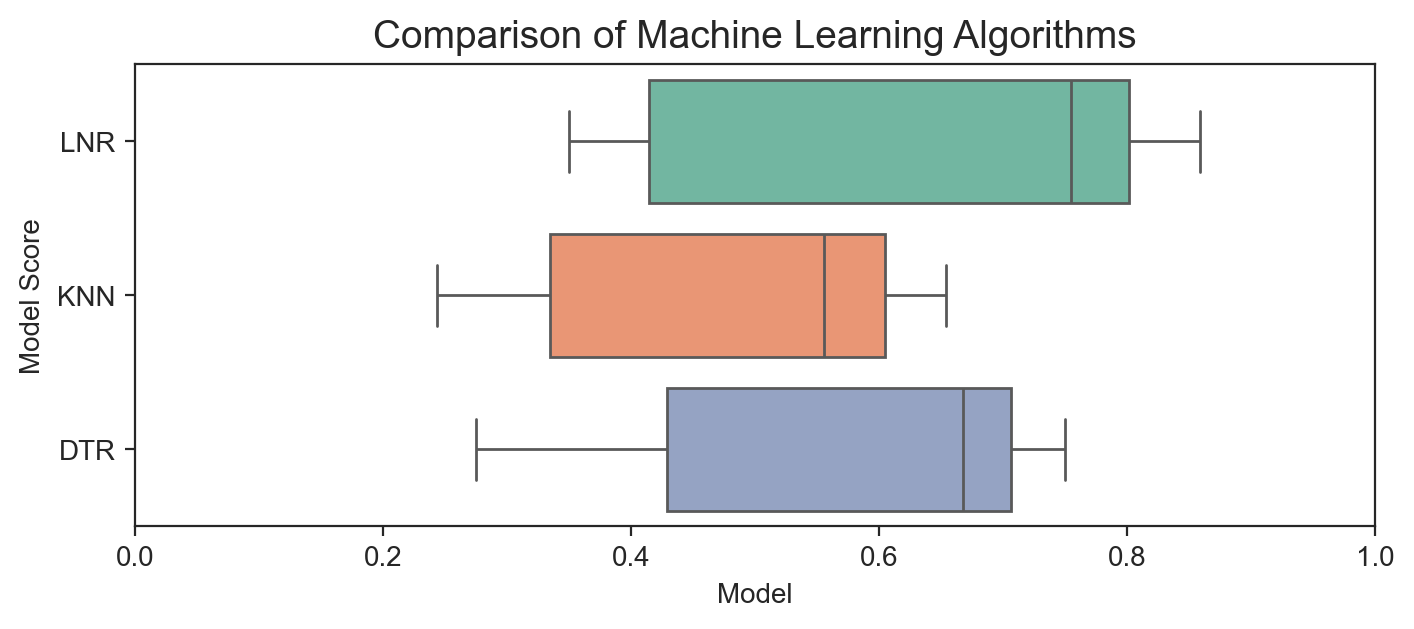

In [2862]:
plt.figure(figsize=(8, 3))
sns.boxplot(result, orient="h")
plt.yticks([0, 1, 2], names)
plt.xlim(0, 1)
plt.title('Comparison of Machine Learning Algorithms',fontsize=14)
plt.gca().set(ylabel='Model Score', xlabel='Model')
# plt.savefig("/Users/hal/Documents/Essays/AutoML/algorithm_box_plot.png", bbox_inches='tight', dpi=240)

# KNN Grid Search

In [2727]:
# Define the parameter grid for 'n_neighbors' from 1 to 20
param_grid = {
    'knn__n_neighbors': list(range(1, 15))
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(knn_pipeline, param_grid, cv=3, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [2736]:
# Display specific columns and sort by 'rank_test_score'
gs_df[[
    'param_knn__n_neighbors', 'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].sort_values('rank_test_score').head()

,param_knn__n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
4,5,0.660818,0.011332,0.475349,0.077665,1
5,6,0.628791,0.012967,0.468091,0.075962,2
6,7,0.606177,0.014832,0.458757,0.076573,3
2,3,0.781279,0.014799,0.454804,0.072347,4
7,8,0.583258,0.011971,0.452340,0.076804,5


In [2737]:
# Retrieve the best parameters found by GridSearchCV
gs_results.best_params_

{'knn__n_neighbors': 5}

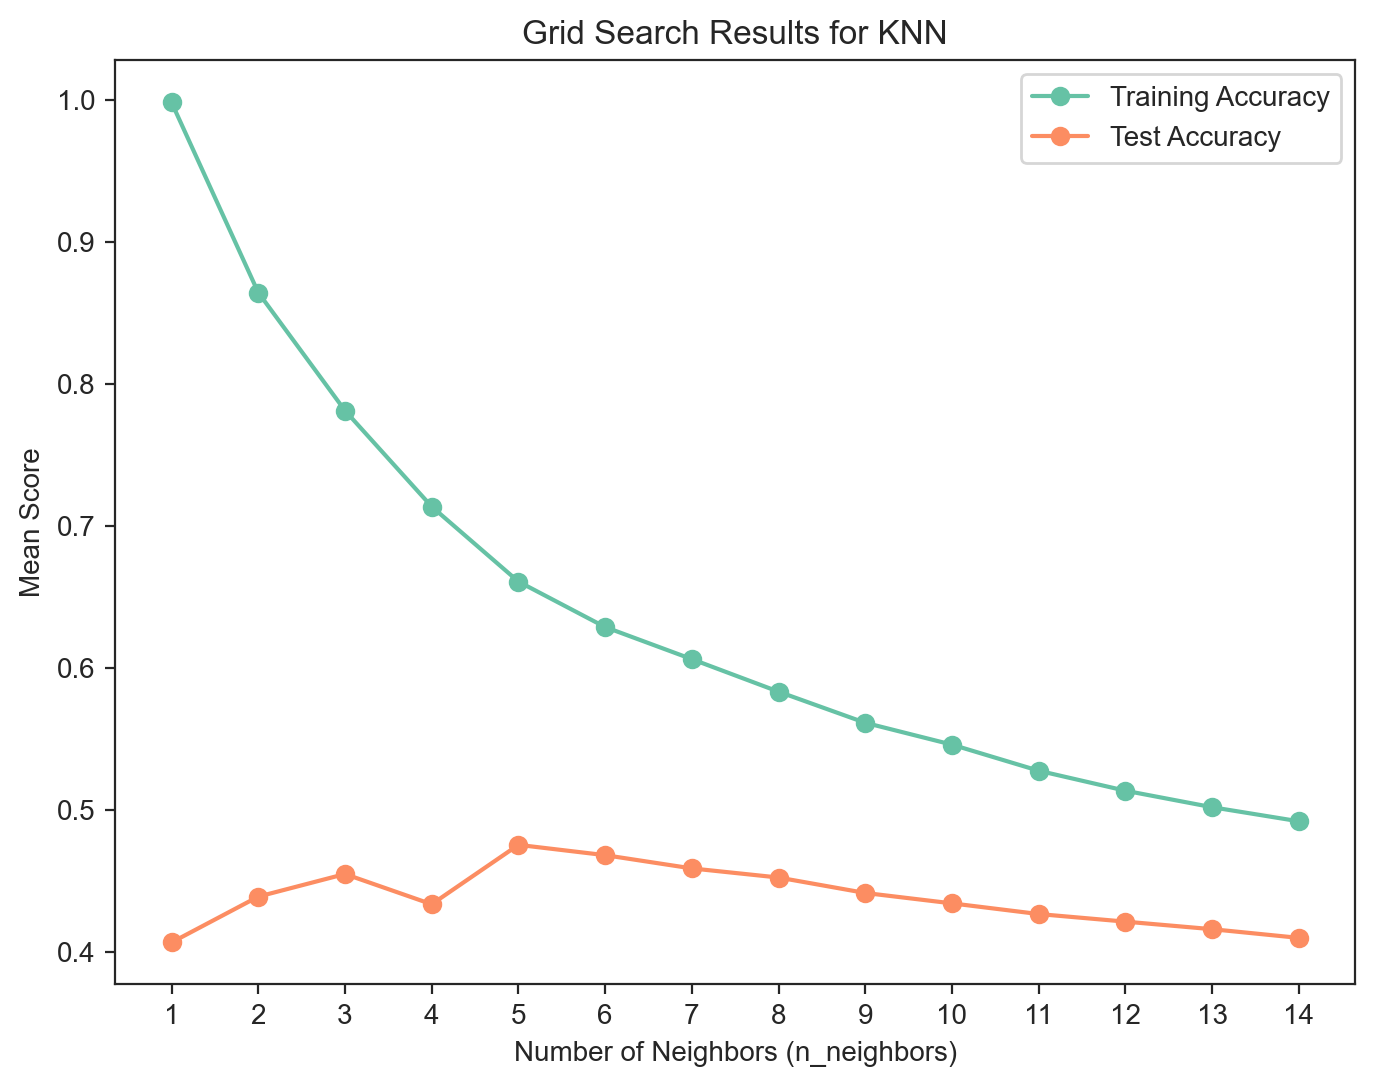

In [ ]:
# Retrieve 'param_n_neighbors' and 'mean_test_score' from the grid search results DataFrame
param_values = gs_df['param_knn__n_neighbors'].astype(int)  # Convert to integer if not already
mean_train_scores = gs_df['mean_train_score'].astype(float)  # Convert to float if not already
mean_test_scores = gs_df['mean_test_score'].astype(float)  # Convert to float if not already

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot both training and test accuracy values
plt.plot(param_values, mean_train_scores, label='Training Accuracy', marker='o')
plt.plot(param_values, mean_test_scores, label='Test Accuracy', marker='o')

# Label the x-axis and y-axis
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Score')

# Set x-axis ticks to the 'n_neighbors' values
plt.xticks(param_values)

# Show plot title and display the plot
plt.title('Grid Search Results for KNN')
plt.legend()
# plt.savefig("/Users/hal/Documents/Essays/AutoML/knn_grid_search.png", bbox_inches='tight', dpi=240)

# DTR Grid Search

In [ ]:
# Define the parameter grid
param_grid = {
    'dtr__max_depth': [10, 20, 30, None],
    'dtr__min_samples_split': [2, 5, 10],
    'dtr__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(dtr_pipeline, param_grid, cv=5, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [27]:
# Display specific columns and sort by 'rank_test_score'
gs_df[[
    'param_dtr__max_depth', 'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].sort_values('rank_test_score').head()

,param_dtr__max_depth,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
29,None,0.977952,0.010233,0.620479,0.254563,1
28,None,0.987965,0.007554,0.610433,0.251906,2
27,None,0.999907,0.000052,0.604873,0.248309,3
20,30,0.942783,0.019365,0.584115,0.237942,4
19,30,0.951023,0.017189,0.577025,0.237954,5


In [28]:
# Retrieve the best parameters found by GridSearchCV
gs_results.best_params_

{'dtr__max_depth': None,
 'dtr__min_samples_leaf': 1,
 'dtr__min_samples_split': 10}

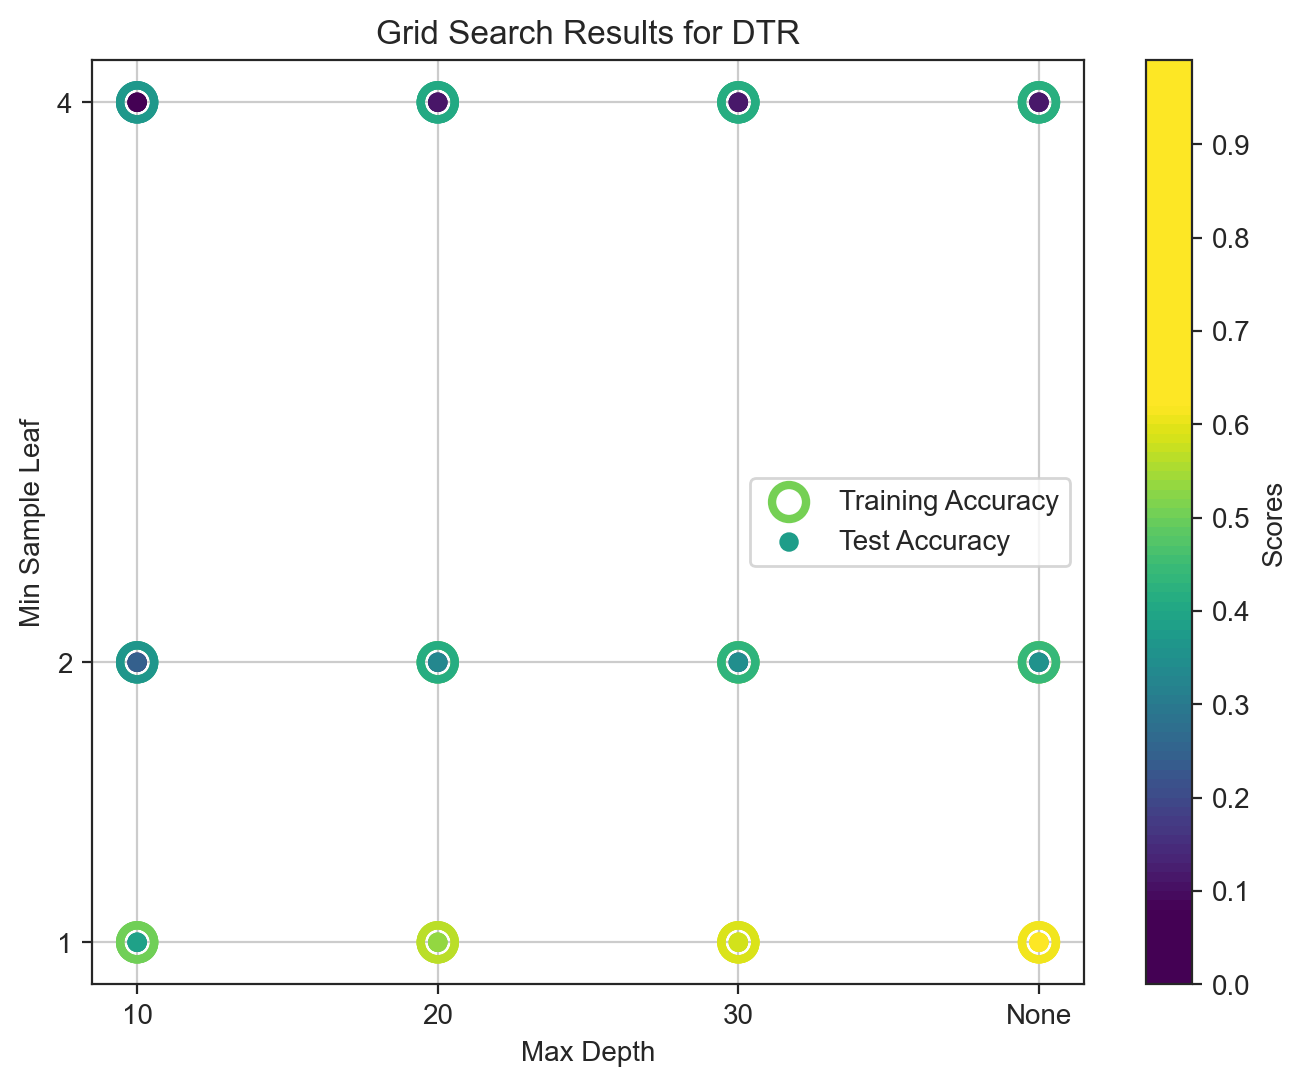

In [146]:
param_depth = gs_df['param_dtr__max_depth'] 
param_depth = param_depth.replace({None: 40})
param_leaf = gs_df['param_dtr__min_samples_leaf'] 

mean_train_scores = gs_df['mean_train_score'].astype(float)
mean_test_scores = gs_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

plt.scatter(
    param_depth, 
    param_leaf, 
    edgecolors=plt.cm.viridis(mean_train_scores),  # Color for edges
    facecolors='none',  # No fill
    s=150,  # Marker size
    linewidths=3,
    label='Training Accuracy'
)

scatter2 = plt.scatter(param_depth, param_leaf, c=mean_test_scores, cmap='viridis', marker="o", label='Test Accuracy')

# Label the x-axis and y-axis
plt.xlabel('Max Depth')
plt.ylabel('Min Sample Leaf')

# Show plot title and display the plot
plt.title('Grid Search Results for DTR')
plt.legend()
plt.xticks([10, 20, 30, 40], ["10", "20", "30", "None"])
plt.yticks([1, 2, 4])
plt.grid(True)
cbar = plt.colorbar(scatter2, boundaries=np.arange(0, 1, 0.01), cmap="viridis")
cbar.set_label('Scores')
plt.savefig("/Users/hal/Documents/Essays/AutoML/dtr_grid_search.png", bbox_inches='tight', dpi=240)

In [165]:
%%capture

from matplotlib.animation import FuncAnimation

# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(param_depth, param_leaf, mean_train_scores, c=mean_train_scores, cmap='viridis')
ax.set_xlabel('Max depth')
ax.set_ylabel('Min Samples Leaf')
ax.set_zlabel('Score')
plt.title('3D Scatter Plot with Seaborn')

# Function to update the view angle for each frame
def update(frame):
    ax.view_init(elev=30, azim=frame)  # Rotate the view
    return ax,

# Create the animation
frames = list(range(200)) + list(range(200, 0, -1))
ani = FuncAnimation(fig, update, frames=frames, interval=20, blit=False);

# Save as MP4
ani.save("3d_scatter_rotation.mp4", writer="ffmpeg", fps=30);

<video src="3d_scatter_rotation.mp4" alt="3d_scatter_rotation" width="701" controls loop />

# Export processed data

In [2731]:
# processed_data = pd.DataFrame(preprocessor.fit_transform(X, y))
# processed_price = pd.DataFrame(num_pipe.fit_transform(y, None))
# processed_data["price"] = processed_price
# processed_data = processed_data.convert_dtypes()
# processed_data.to_csv("processed_data.csv", index=False)
# processed_data

# Plot results

In [2732]:
knn_pipeline.fit(X_train, y_train)
actual = y_test.to_numpy().ravel()
predicted = knn_pipeline.predict(X_test).ravel()

prediction_df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})

In [2733]:
# Scale price to 1000s of pounds for readability
prediction_df["Actual"] = prediction_df["Actual"]/1000
prediction_df["Predicted"] = prediction_df["Predicted"]/1000

In [2734]:
plot_sample_size = 12

df_plot = prediction_df.sample(plot_sample_size, random_state=1)

X_cars = X_test.reset_index(drop=True)[["year_of_registration", "standard_colour", "standard_make", "standard_model"]]
X_cars_sample = X_cars.loc[df_plot.index]
X_cars_sample["year_of_registration"] = X_cars_sample["year_of_registration"].astype(int)
X_cars_sample["name"] = X_cars_sample["year_of_registration"].astype(str) + " " +  X_cars_sample["standard_make"] + " " + X_cars_sample["standard_model"]

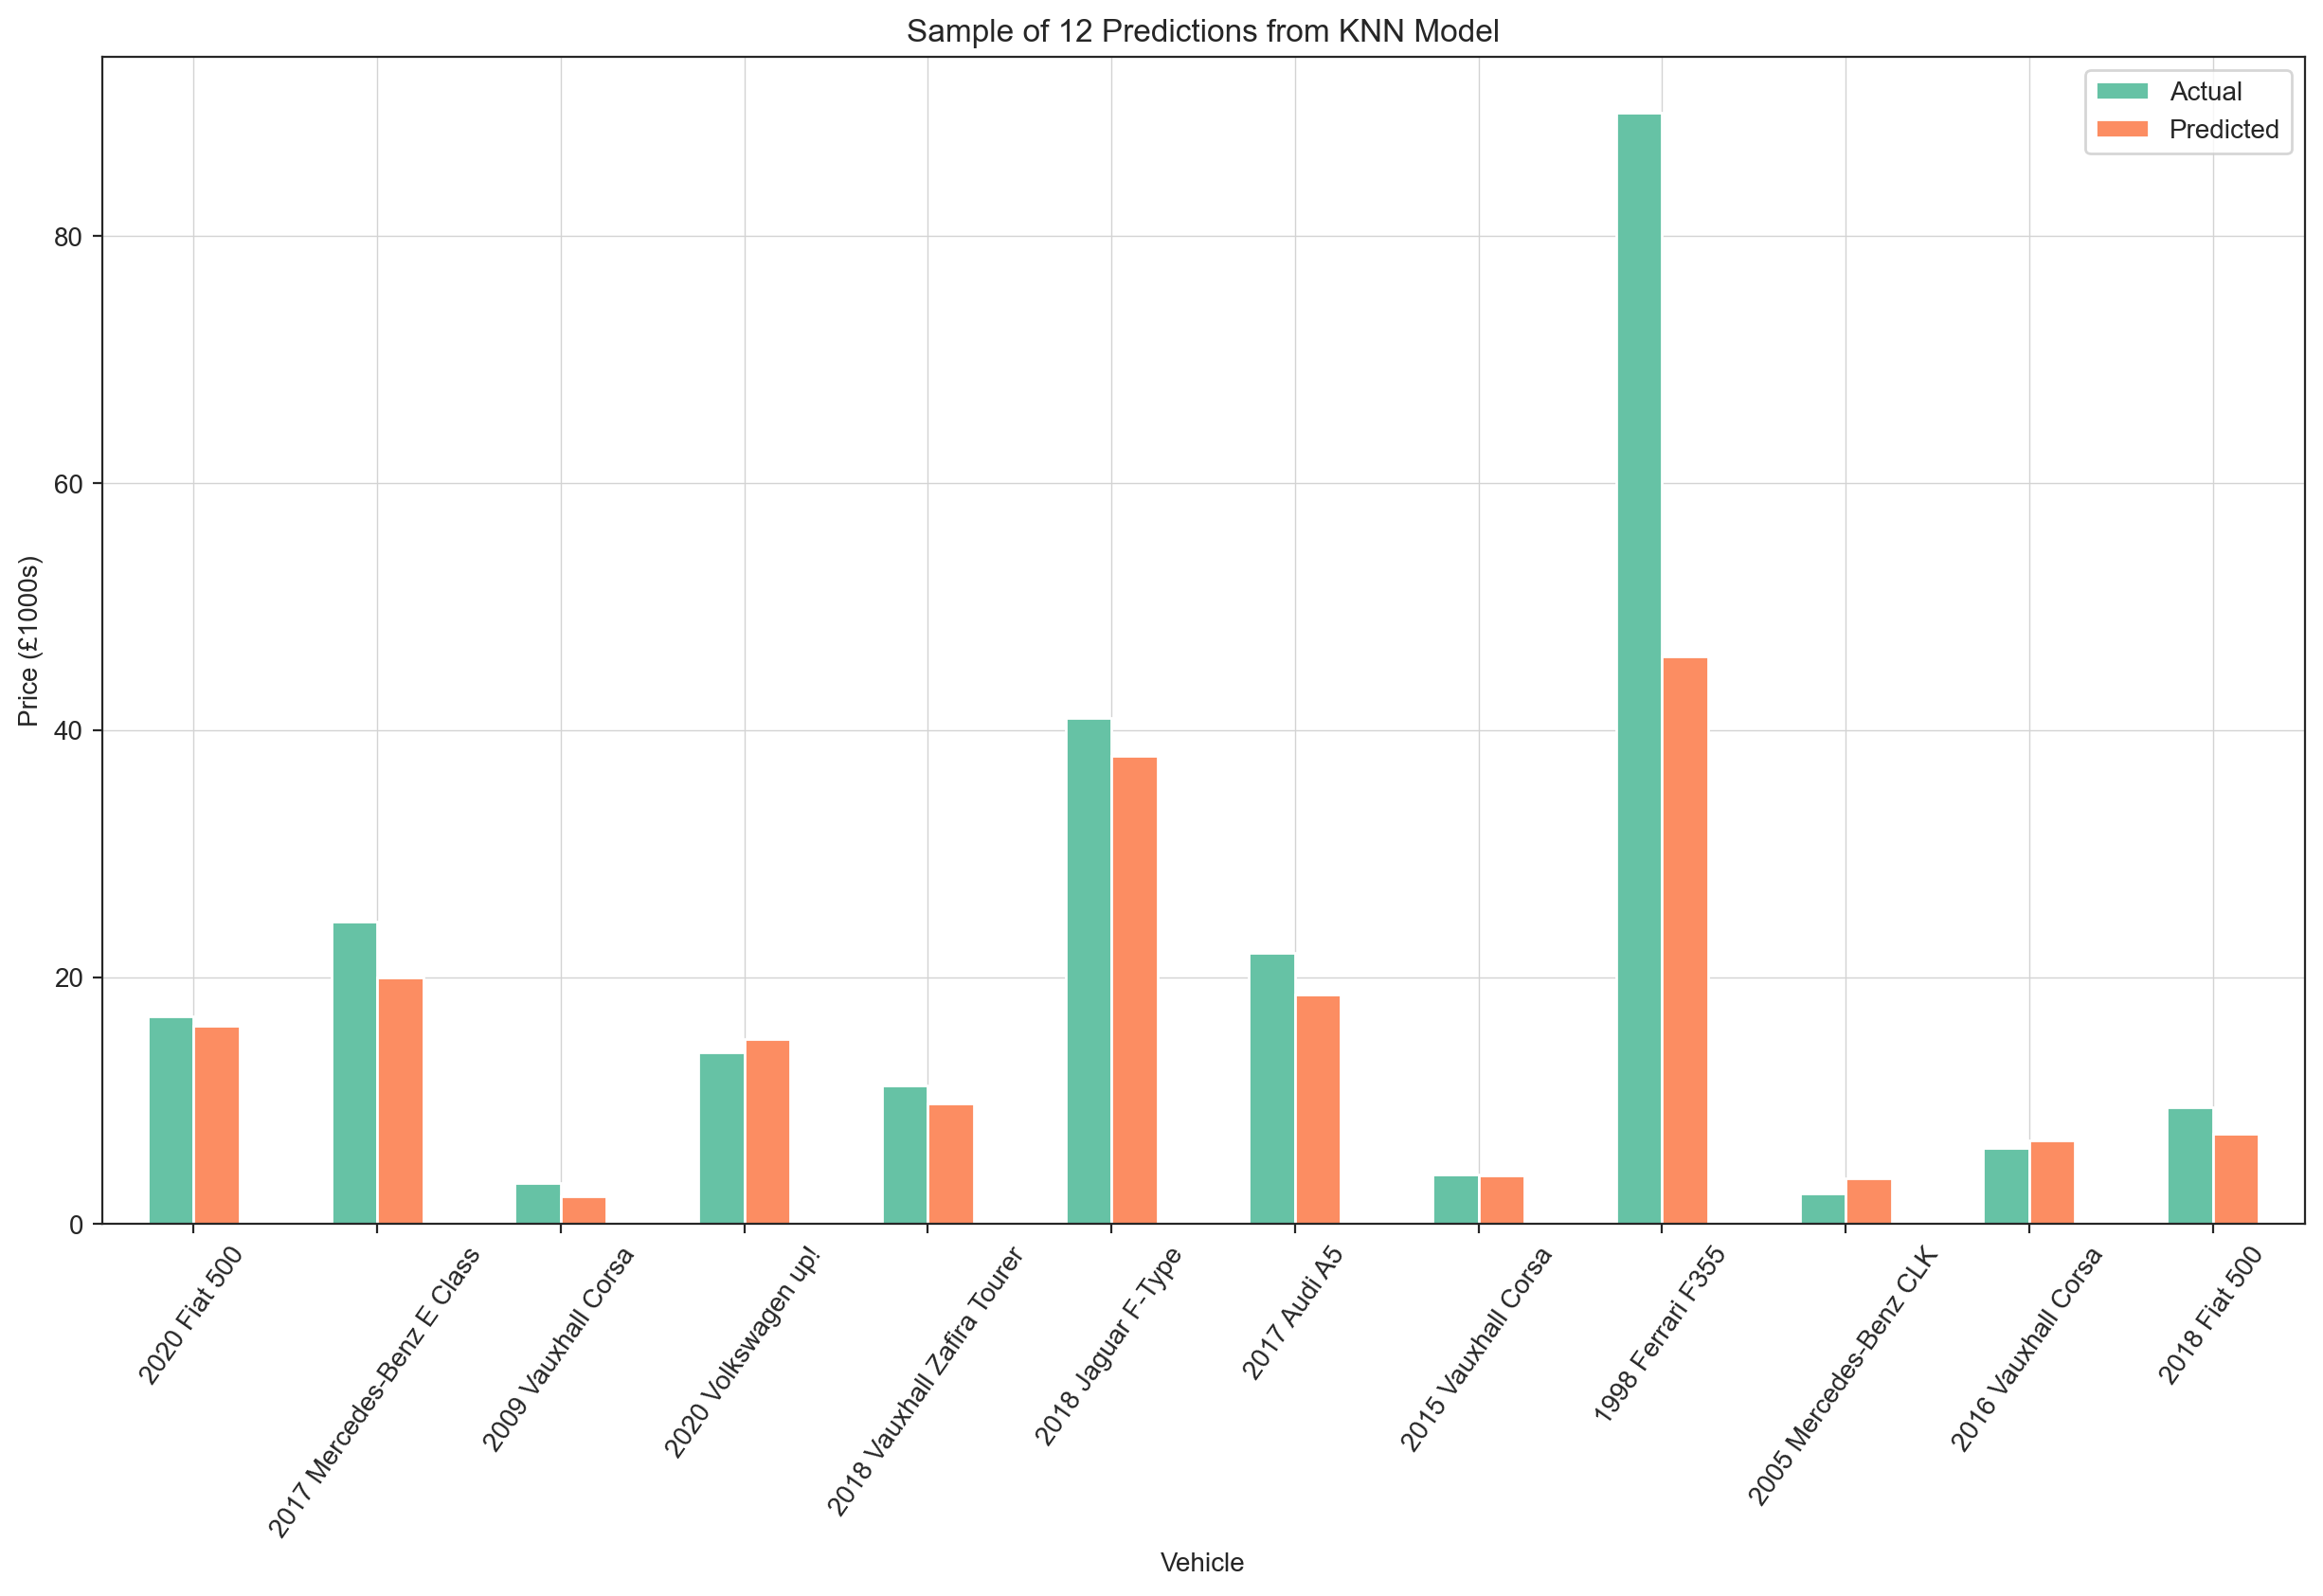

In [2735]:
df_plot.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgray')
plt.xticks(ticks=np.arange(0, plot_sample_size), labels=X_cars_sample["name"], rotation=55)
plt.title("Sample of 12 Predictions from KNN Model")
plt.ylabel("Price (£1000s)")
plt.xlabel("Vehicle");